In [1]:
import pandas as pd
import dash
from dash import dcc, html
import dash_daq as daq

import numpy as np
import plotly.express as px
import psycopg2
import pyodbc
import mysql.connector
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from decimal import Decimal

import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Redshift 연결 정보
# Redshift 연결 정보
host='dev-data-etl-rs.ct0xxcn9xq5g.ap-northeast-2.redshift.amazonaws.com'
dbname='data_analysis_db'
user='stella'
password='iWntan282E5jJQc'
port='5439'

In [3]:
# Redshift에 연결
conn = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password,
    port=port
)

In [4]:
# 커서 생성
cursor = conn.cursor()
# SQL 쿼리 실행 (예시: frigga_sample 테이블에서 모든 데이터를 조회)
cursor.execute("""                          
                    SELECT 
                        *
                    FROM 
                        "data_analysis_db"."da_schema"."t_frigga_broken_target"
                    WHERE 1=1
                    ORDER BY device_serial ASC
                ;
               """)

# 결과 가져오기
rows = cursor.fetchall()

# 컬럼명 가져오기
columns = [desc[0] for desc in cursor.description]

# DataFrame으로 변환
broken = pd.DataFrame(rows, columns=columns)

# 커서와 연결 종료
cursor.close()
conn.close()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
# 독립변수 / 종속변수 구분# 독립 변수와 종속 변수 정의
X = broken[['duration_time', 'duration_day', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi', 'max_humi', 'mean_humi', 'std_humi', 
                'min_acc', 'max_acc', 'mean_acc', 'std_acc', 'q1_temp', 'q3_temp', 'temp_start', 'temp_end', 'q1_humi', 'q3_humi', 
                'humi_start', 'humi_end', 'q1_acc', 'q3_acc', 'acc_start', 'acc_end', 'ta_min', 'ta_max', 'ta_mean', 'ta_std', 
                'ta_q1', 'ta_q3', 'ws1_min', 'ws1_max', 'ws1_mean', 'ws1_std', 'ws1_q1', 'ws1_q3', 'ws10_min', 'ws10_max', 
                'ws10_mean', 'ws10_std', 'ws10_q1', 'ws10_q3', 'hm_min', 'hm_max', 'hm_mean', 'hm_std', 'hm_q1', 'hm_q3', 
                'alert_temp_sum', 'alert_humi_sum', 'alert_acc_sum']]

# y = df_broken['broken_yn']
y = broken['broken_yn'].astype(int)

정확도: 0.9375
ROC AUC 점수: 1.0000
분류 보고서:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.78      1.00      0.88         7

    accuracy                           0.94        32
   macro avg       0.89      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32



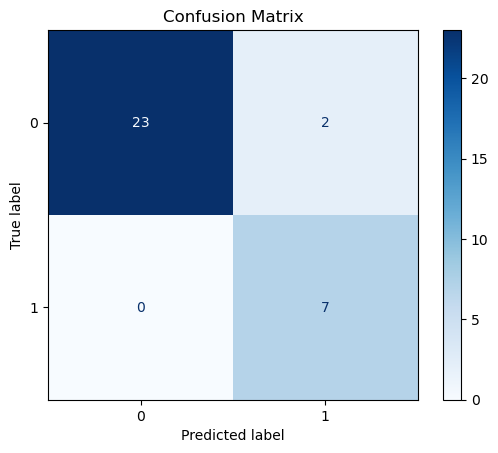

    broken_yn  predicted_proba
0           0              NaN
1           1              NaN
2           1              NaN
3           0              NaN
4           0              NaN
..        ...              ...
151         0              NaN
152         0         0.033635
153         0              NaN
154         1              NaN
155         0              NaN

[156 rows x 2 columns]


In [7]:
# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 세트에 맞춰 스케일링
X_test_scaled = scaler.transform(X_test)  # 테스트 세트에 동일한 스케일링 적용

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 1에 대한 확률

# 예측 결과 평가
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")
print("분류 보고서:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_lr)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 예측 확률을 데이터프레임에 추가
X_test_with_proba = X_test.copy()  # X_test의 복사본 생성
X_test_with_proba['predicted_proba'] = y_pred_proba  # 새로운 컬럼 추가

# 원래 데이터프레임에 추가 (원하는 경우)
df_broken_prob = broken.copy()  # 원본 데이터프레임 복사
df_broken_prob.loc[X_test.index, 'predicted_proba'] = y_pred_proba  # 예측 확률 추가

# 결과 확인
print(df_broken_prob[['broken_yn', 'predicted_proba']])

### Dash Board 예시 만들기

In [8]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import pandas as pd
import numpy as np

In [9]:
# 데이터 생성
total_items = 2000
normal_items = 1800
damaged_items = 200

# 파손 비율 데이터
labels = ['Normal', 'Damaged']
values = [normal_items, damaged_items]

# 로지스틱 회귀 예측 결과 (예시)
predicted_probability = 0.65  # 예시 확률값

# 온도 및 습도 데이터 생성 (2025년 01월 03일부터 2025년 02월 23일까지)
date_range = pd.date_range(start='2025-01-03', end='2025-02-23')
temperature_data = np.random.uniform(low=-10, high=-5, size=len(date_range) - 1).tolist()
temperature_data.append(-12)  # 일탈 케이스 추가
np.random.shuffle(temperature_data)  # 일탈 케이스를 랜덤하게 섞기
humidity_data = np.random.uniform(low=30, high=70, size=len(date_range))  # 습도 데이터 생성
temperature_df = pd.DataFrame({'Date': date_range, 'Temperature': temperature_data, 'Humidity': humidity_data})

# 충격량 데이터 생성 (2025년 01월 03일부터 2025년 02월 23일까지)
shock_data = np.random.uniform(low=0.0, high=2.0, size=len(date_range)).tolist()
shock_data[-1] = 2.5  # 마지막 값을 일탈 케이스로 설정
np.random.shuffle(shock_data)  # 일탈 케이스를 랜덤하게 섞기
shock_df = pd.DataFrame({'Date': date_range, 'Shock': shock_data})


# 기울기 데이터 생성 (예시)
tiltx = np.random.uniform(low=-1.0, high=1.0, size=len(date_range))
tilty = np.random.uniform(low=-1.0, high=1.0, size=len(date_range))
tiltz = np.random.uniform(low=-1.0, high=1.0, size=len(date_range))

# 기울기 데이터프레임 생성
tilt_df = pd.DataFrame({'Date': date_range, 'TiltX': tiltx, 'TiltY': tilty, 'TiltZ': tiltz})


# 향후 일주일치 예측값 (임의로 생성, 정상 범위로 설정)
future_dates = pd.date_range(start='2025-02-24', periods=7)
future_temperatures = np.random.uniform(low=-10, high=-5, size=len(future_dates))
future_humidity = np.random.uniform(low=30, high=70, size=len(future_dates))
future_temperature_df = pd.DataFrame({'Date': future_dates, 'Temperature': future_temperatures, 'Humidity': future_humidity})

# 온도 일탈 알림 생성
anomalies = temperature_df[(temperature_df['Temperature'] < -10) | (temperature_df['Temperature'] > -5)]
anomaly_alert_dates = anomalies['Date'].tolist()  # 일탈 발생 날짜 리스트

# 충격량 일탈 알림 생성
shock_anomalies = shock_df[shock_df['Shock'] > 2.0]
shock_anomaly_alert_dates = shock_anomalies['Date'].tolist()  # 일탈 발생 날짜 리스트

damage_rate = (damaged_items / total_items) * 100  # 파손 비율 계산

In [10]:
# Dash 앱 초기화
app = dash.Dash(__name__)

###### GAPMINDER
# Gapminder 데이터 로드
df = px.data.gapminder().query("year == 2007")

# 특정 항구의 위험 표시를 위한 데이터 생성
ports_data = {
    'country': ['South Africa', 'Mexico'],
    'iso_alpha': ['ZAF', 'MEX'],
    'lat': [-30.5595, 23.6345],  # 남아프리카 공화국과 멕시코의 위도
    'lon': [22.9375, -102.5528],  # 남아프리카 공화국과 멕시코의 경도
    'risk': [1, 1]  # 위험 표시를 위한 값
}

ports_df = pd.DataFrame(ports_data)

# 전세계 지도 시각화
fig = px.scatter_geo(df, locations="iso_alpha",
                     color="continent",  # 마커 색상 설정
                     hover_name="country",  # 호버 정보에 추가할 열
                     size="pop",  # 마커 크기
                     projection="natural earth",
                     title="전세계 물류 트래킹 - 위치별 파손 발생 위험 예측 서비스")

# 위험 항구 표시
fig.add_trace(go.Scattergeo(
    lon=ports_df['lon'],
    lat=ports_df['lat'],
    text=ports_df['country'],
    mode='markers+text',
    marker=dict(color='red', size=10, symbol='circle'),
    name='위험 항구'
))

# 임의의 경로 이동 표시 (예: 남아프리카에서 멕시코로 이동)
fig.add_trace(go.Scattergeo(
    lon=[ports_df['lon'][0], ports_df['lon'][1]],  # 남아프리카 -> 멕시코
    lat=[ports_df['lat'][0], ports_df['lat'][1]],
    mode='lines',
    line=dict(width=2, color='blue'),
    name='이동 경로'
))


# 화물의 GPS 경로 데이터 생성 (예시)
gps_data = {
    'latitude': [37.5665, 37.5700, 37.5750, 37.5800, 37.5850, 37.5900],
    'longitude': [126.9780, 126.9800, 126.9820, 126.9850, 126.9900, 126.9950],
    'alert': [0, 0, 1, 0, 1, 0]  # 1은 경고 구간, 0은 일반 구간
}

gps_df = pd.DataFrame(gps_data)

# Geofencing 구역 설정 (예시: 특정 경계)
geofence_lat = [37.5700, 37.5800, 37.5800, 37.5700, 37.5700]
geofence_lon = [126.9780, 126.9780, 126.9900, 126.9900, 126.9780]


###### GEOFENCING
# 지도 시각화
fig_geo = go.Figure()

# Geofencing 구역 추가
fig_geo.add_trace(go.Scattergeo(
    lon=geofence_lon,
    lat=geofence_lat,
    mode='lines',
    line=dict(color='red', width=2),
    name='Geofence Area'
))

# 화물 경로 추가
fig_geo.add_trace(go.Scattergeo(
    lon=gps_df['longitude'],
    lat=gps_df['latitude'],
    mode='markers+lines',
    marker=dict(size=8, color='blue'),
    name='Cargo Path'
))

# 경고 구간 표시
alert_points = gps_df[gps_df['alert'] == 1]
fig_geo.add_trace(go.Scattergeo(
    lon=alert_points['longitude'],
    lat=alert_points['latitude'],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Alert Points'
))

# 레이아웃 설정
fig_geo.update_layout(
    title='Geofencing기반 구간 알림 서비스',
    geo=dict(
        scope='asia',
        showland=True,
        landcolor='lightgray',
        countrycolor='white'
    )
)

# 기울기 일탈 알림 생성
# 특정 한 케이스를 빨간색으로 표시 (예: 첫 번째 데이터 포인트)
outlier_index = 0  # 일탈 케이스의 인덱스
colors = ['red' if i == outlier_index else 'blue' for i in range(len(tilt_df))]  # 색상 리스트 생성


## 충격량 빈도
# 데이터프레임 생성
### 충격량 막대 빈도 시각화
# 날짜 범위 생성 (2025-01-03부터 2025-02-23까지)
dt_rg = pd.date_range(start='2025-01-03', end='2025-02-23', freq='D')

# 각 날짜별 샘플 수 (400~600개 사이의 랜덤 수 생성)
np.random.seed(42)
samples_per_day = np.random.randint(150, 601, size=len(dt_rg))

# 각 날짜별 충격량 생성
shock_values = []
for n_samples in samples_per_day:
    # 안전(0~0.7), 주의(0.7~1.3), 위험(1.3~2.0) 비율로 충격량 분포
    safety = np.random.uniform(0, 0.7, int(n_samples * 0.8))  # 80% 안전
    caution = np.random.uniform(0.7, 1.5, int(n_samples * 0.19))  # 15% 주의
    danger = np.random.uniform(1.5, 2.0, int(n_samples * 0.01))  # 5% 위험
    shock_values.extend(np.concatenate([safety, caution, danger]))

# 각 날짜에 대해 충격량 상태 할당
date_list = []
condition_list = []

# 충격량 상태를 각 날짜에 매핑
for date, n_samples in zip(dt_rg, samples_per_day):
    for _ in range(n_samples):
        date_list.append(date)
        condition_list.append('안전' if np.random.uniform(0, 2) < 0.7 else '주의' if np.random.uniform(0, 2) < 1.5 else '위험')


bar_shock = pd.DataFrame({
    'date': date_list,
    'condition': condition_list
})
               
# 각 날짜별 상태 빈도 계산
condition_counts = bar_shock.groupby(['date', 'condition']).size().unstack(fill_value=0)
# 시각화: 각 날짜별 상태 빈도 막대 그래프
fig_bar = go.Figure()

# 각 상태에 대해 트레이스를 추가
for condition in ['안전', '주의', '위험']:
    fig_bar.add_trace(go.Bar(
        x=condition_counts.index,  # 날짜
        y=condition_counts[condition],  # 상태 빈도
        name=condition,
        marker_color='green' if condition == '안전' else ('yellow' if condition == '주의' else 'red')
    ))

# 레이아웃 설정
fig_bar.update_layout(
    title='일자별 충격량 상태 빈도',
    xaxis_title='날짜',
    yaxis_title='빈도',
    barmode='stack',  # 스택형 그래프
    xaxis=dict(tickangle=-45),  # 날짜 레이블 각도 조정
)
        

position = {
    "Place": ["부산항"],
    "Latitude": [35.1035355],
    "Longitude": [129.0423688]
}

# 데이터 프레임 생성
ps = pd.DataFrame(position)

# Plotly Express를 사용하여 지도 생성
fig_position = px.scatter_mapbox(
    ps,  # 데이터 프레임 사용
    lat="Latitude", 
    lon="Longitude", 
    zoom=15,  # 지도 확대 레벨
    height=300,  # 지도 높이
    width=500,  # 지도 너비
    hover_name="Place",  # 호버 텍스트
)

# Mapbox 스타일 설정
fig_position.update_layout(mapbox_style="open-street-map")




##########################################################################################################################################################################
# 대시보드 레이아웃 설정
app.layout = html.Div([
    html.H1("데이터 프로덕트 AI기반 내러티브 분석 시각화"),
      
    # TEXT 설명
    html.Div([
        html.H2("ML기반 모델링 산출물 시각화 예시"),
        html.P("서비스 목표: AI 기반 데이터 프로덕트를 통해 물류 운송 리스크를 감지하고, 예측 및 대응을 위한 의사결정 서비스를 제공", style={'font-size': '20px'}),
        html.P("서비스 내용: 시나리오에 따른 산출물을 시각화 예시로 나타내고, ML기반의 서비스 정보 제공", style={'font-size': '20px'})
    ], style={'margin-top': '20px', 'padding': '20px', 'border': '1px solid #ccc', 'border-radius': '5px'}
    ),
    
    
    ##########################################################################################################################################################################  

    html.Div([
        html.H2("B/L번호: BY2103002"),
        html.H3("디바이스명: T057A055"),
        html.P("해당 디바이스로부터 실시간으로 정보를 수집하여 서비스를 제공합니다.", style={'font-size': '20px'}),
        html.P("디바이스가 여러개인 경우.", style={'font-size': '20px'})
    ], style={
            'margin-top': '20px',
            'padding': '20px',
            'border': '1px solid #ccc',
            'border-radius': '5px',
            'text-align': 'center',
            'width': '48%'  # 왼쪽 영역 너비 설정
        }
    ),

    ##########################################################################################################################################################################     
    # 게이지 차트
    dcc.Graph(
        id='gauge-chart',
        figure=go.Figure(go.Indicator(
            mode="gauge+number",
            value=predicted_probability,
            title={'text': "실시간 파손 예측 확률"},
            gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': "blue"},
                'steps': [
                    {'range': [0, 0.3], 'color': "green"},  # 안전
                    {'range': [0.3, 0.7], 'color': "yellow"},  # 주의
                    {'range': [0.7, 1], 'color': "red"}  # 위험
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 0.7  # 위험 경계
                }
            }
        )),
        # style={'width': '48%', 'display': 'inline-block'}  # 그래프 48% 크기, 가로로 나란히    
        style={
            'width': '48%',
            'display': 'inline-block',  # Flexbox를 사용하여 레이아웃 설정
            'justify-content': 'center',  # 가로 가운데 정렬
            'align-items': 'center'  # 세로 가운데 정렬
            }
        ),   
        
    ##########################################################################################################################################################################    

    ##########################################################################################################################################################################  
    
    # 전세계 물류 트래킹 지도
    dcc.Graph(
        id='world-map',
        figure=fig  # 위에서 생성한 fig 객체를 여기에 할당
    ),  
 
    dcc.Graph(
        id='geofencing-map',
        figure=fig_geo
    ),
    
    # 온도 및 습도 라인 차트
    html.Div([
        dcc.Graph(
            id='temperature-line-chart',
            figure=go.Figure()
                .add_trace(go.Scatter(
                    x=temperature_df['Date'], 
                    y=temperature_df['Temperature'], 
                    mode='lines+markers', 
                    name='과거 온도',
                    marker=dict(color='blue')
                ))
                .add_trace(go.Scatter(
                    x=future_temperature_df['Date'], 
                    y=future_temperature_df['Temperature'], 
                    mode='lines+markers', 
                    name='예측 온도', 
                    line=dict(dash='dash'),
                    marker=dict(color='orange')
                ))
                .add_trace(go.Scatter(
                    x=anomaly_alert_dates, 
                    y=[-12] * len(anomaly_alert_dates),  # 일탈 온도
                    mode='markers+text', 
                    name='온도 일탈', 
                    marker=dict(color='red', size=10, symbol='x'),
                    text=['온도 일탈'] * len(anomaly_alert_dates),  # 팝업 텍스트
                    textposition='top center'
                ))
                .update_layout(title='디바이스 온도 측정(Unit/건)', xaxis_title='날짜', yaxis_title='온도 (°C)')
        ),
        
        dcc.Graph(
            id='humidity-line-chart',
            figure=go.Figure()
                .add_trace(go.Scatter(
                    x=temperature_df['Date'], 
                    y=temperature_df['Humidity'], 
                    mode='lines+markers', 
                    name='과거 습도',
                    marker=dict(color='green')
                ))
                .add_trace(go.Scatter(
                    x=future_temperature_df['Date'], 
                    y=future_humidity, 
                    mode='lines+markers', 
                    name='예측 습도', 
                    line=dict(dash='dash'),
                    marker=dict(color='lightgreen')
                ))
                .update_layout(title='디바이스 습도 측정(Unit/건)', xaxis_title='날짜', yaxis_title='습도 (%)')
        ),
        
        # 충격량 라인 차트 추가
        dcc.Graph(
            id='shock-line-chart',
            figure=go.Figure()
                .add_trace(go.Scatter(
                    x=shock_df['Date'], 
                    y=shock_df['Shock'], 
                    mode='lines+markers', 
                    name='충격량',
                    marker=dict(color='purple')
                ))
                .add_trace(go.Scatter(
                    x=shock_anomaly_alert_dates, 
                    y=[2.5] * len(shock_anomaly_alert_dates),  # 일탈 충격량
                    mode='markers+text', 
                    name='충격량 일탈', 
                    marker=dict(color='red', size=10, symbol='x'),
                    text=['충격량 일탈'] * len(shock_anomaly_alert_dates),  # 팝업 텍스트
                    textposition='top center'
                ))
                .add_trace(go.Scatter(
                    x=shock_df['Date'][(shock_df['Shock'] >= 1.5) & (shock_df['Shock'] <= 2.0)], 
                    y=shock_df['Shock'][(shock_df['Shock'] >= 1.5) & (shock_df['Shock'] <= 2.0)], 
                    mode='markers', 
                    name='파손 발생 위험 구간', 
                    marker=dict(color='orange', size=8, symbol='circle'),
                    text=['위험 구간'] * len(shock_df[(shock_df['Shock'] >= 1.5) & (shock_df['Shock'] <= 2.0)]),  # 팝업 텍스트
                    textposition='top center'
                ))
                .update_layout(title='디바이스 충격량 측정(Unit/건)', xaxis_title='날짜', yaxis_title='충격량')
        ),
        
        ### 충격량 막대 빈도 그래프
        dcc.Graph(
            id='shock-frequency-bar-chart',
            figure=fig_bar
        ),
        
        # 기울기 정보 시각화 추가
        dcc.Graph(
            id='tilt-3d-chart',
            figure=go.Figure(data=[
                go.Scatter3d(
                    x=tilt_df['TiltX'],
                    y=tilt_df['TiltY'],
                    z=tilt_df['TiltZ'],
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=colors,  # 색상 리스트 사용
                        opacity=0.8
                    ),
                    text=tilt_df['Date'].dt.strftime('%Y-%m-%d'),  # 날짜 표시
                    hoverinfo='text'
                )
            ]).update_layout(
                title='디바이스 기울기 정보 시각화(Unit/건)', 
                scene=dict(
                    xaxis_title='TiltX', 
                    yaxis_title='TiltY', 
                    zaxis_title='TiltZ'
                )
            ),
            style={'height': '600px', 'width': '100%', 'display': 'flex', 'justify-content': 'center'}
        )
    ], style={'display': 'flex', 'flex-direction': 'column', 'gap': '20px', 'margin-top': '20px', 'padding': '20px'})
])

# 서버 실행
if __name__ == '__main__':
    app.run_server(debug=True)

In [24]:
import requests
import pdfkit

# 웹 페이지 URL
url = 'http://127.0.0.1:8050/'

# 출력될 PDF 파일 경로
output_pdf_path = 'dashboard.pdf'

# pdfkit 설정 (wkhtmltopdf 경로가 필요한 경우 설정)
config = pdfkit.configuration(wkhtmltopdf='/usr/local/bin/wkhtmltopdf')

# URL을 PDF로 변환
pdfkit.from_url(url, output_pdf_path, configuration=config)

print("PDF 파일이 생성되었습니다.")

PDF 파일이 생성되었습니다.


## 기울기 3D 시각화

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [25]:
# 직육면체의 중심과 각 축의 길이
center = [0, 0, 0]
lengths = [2, 3, 4]

# 디바이스의 크기
device_size = [0.5, 0.5, 0.5]

# 직육면체의 8개 꼭지점 계산
def get_corners(center, lengths):
    dx, dy, dz = lengths[0] / 2, lengths[1] / 2, lengths[2] / 2
    corners = [
        [center[0] - dx, center[1] - dy, center[2] - dz],
        [center[0] + dx, center[1] - dy, center[2] - dz],
        [center[0] + dx, center[1] + dy, center[2] - dz],
        [center[0] - dx, center[1] + dy, center[2] - dz],
        [center[0] - dx, center[1] - dy, center[2] + dz],
        [center[0] + dx, center[1] - dy, center[2] + dz],
        [center[0] + dx, center[1] + dy, center[2] + dz],
        [center[0] - dx, center[1] + dy, center[2] + dz]
    ]
    return np.array(corners)

# 디바이스의 꼭지점 계산 (TiltZ, TiltY 면에 부착)
def get_device_corners(center, device_size):
    dx, dy, dz = device_size[0] / 2, device_size[1] / 2, device_size[2] / 2
    base_x = center[0] + lengths[0] / 2 - dx  # 직육면체의 오른쪽 면에 부착
    base_y = center[1] + lengths[1] / 2 - dy  # 직육면체의 상단 면에 부착
    base_z = center[2] + lengths[2] / 2 - dz  # 직육면체의 전면에 부착
    device_corners = [
        [base_x - dx, base_y - dy, base_z - dz],
        [base_x + dx, base_y - dy, base_z - dz],
        [base_x + dx, base_y + dy, base_z - dz],
        [base_x - dx, base_y + dy, base_z - dz],
        [base_x - dx, base_y - dy, base_z + dz],
        [base_x + dx, base_y - dy, base_z + dz],
        [base_x + dx, base_y + dy, base_z + dz],
        [base_x - dx, base_y + dy, base_z + dz]
    ]
    return np.array(device_corners)

corners = get_corners(center, lengths)
device_corners = get_device_corners(center, device_size)

# Plotly 3D plot 생성
fig = go.Figure(data=[
    go.Mesh3d(
        x=corners[:, 0],
        y=corners[:, 1],
        z=corners[:, 2],
        color='blue',
        opacity=0.3,
        alphahull=0
    ),
    go.Mesh3d(
        x=device_corners[:, 0],
        y=device_corners[:, 1],
        z=device_corners[:, 2],
        color='grey',
        opacity=0.5,
        alphahull=0
    )
])

# 축 설정
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[min(corners[:, 0]) - 1, max(corners[:, 0]) + 1]),
        yaxis=dict(range=[min(corners[:, 1]) - 1, max(corners[:, 1]) + 1]),
        zaxis=dict(range=[min(corners[:, 2]) - 1, max(corners[:, 2]) + 1]),
        xaxis_title='TiltX',
        yaxis_title='TiltY',
        zaxis_title='TiltZ'
    ),
    title="3D 직육면체와 디바이스 시각화"
)

# 플롯 표시
fig.show()

In [26]:
# 직육면체의 중심과 각 축의 길이
center = [0, 0, 0]
lengths = [2, 3, 4]

# 디바이스의 크기
device_size = [0.5, 0.5, 0.5]

# 직육면체의 8개 꼭지점 계산
def get_corners(center, lengths):
    dx, dy, dz = lengths[0] / 2, lengths[1] / 2, lengths[2] / 2
    corners = [
        [center[0] - dx, center[1] - dy, center[2] - dz],
        [center[0] + dx, center[1] - dy, center[2] - dz],
        [center[0] + dx, center[1] + dy, center[2] - dz],
        [center[0] - dx, center[1] + dy, center[2] - dz],
        [center[0] - dx, center[1] - dy, center[2] + dz],
        [center[0] + dx, center[1] - dy, center[2] + dz],
        [center[0] + dx, center[1] + dy, center[2] + dz],
        [center[0] - dx, center[1] + dy, center[2] + dz]
    ]
    return np.array(corners)

# 디바이스의 꼭지점 계산
def get_device_corners(center, device_size):
    dx, dy, dz = device_size[0] / 2, device_size[1] / 2, device_size[2] / 2
    base_x = center[0] + lengths[0] / 2 - dx  # 직육면체의 오른쪽 면에 부착
    base_y = center[1] + lengths[1] / 2 - dy  # 직육면체의 상단 면에 부착
    base_z = center[2] + lengths[2] / 2 - dz  # 직육면체의 전면에 부착
    device_corners = [
        [base_x - dx, base_y - dy, base_z - dz],
        [base_x + dx, base_y - dy, base_z - dz],
        [base_x + dx, base_y + dy, base_z - dz],
        [base_x - dx, base_y + dy, base_z - dz],
        [base_x - dx, base_y - dy, base_z + dz],
        [base_x + dx, base_y - dy, base_z + dz],
        [base_x + dx, base_y + dy, base_z + dz],
        [base_x - dx, base_y + dy, base_z + dz]
    ]
    return np.array(device_corners)

corners = get_corners(center, lengths)
device_corners = get_device_corners(center, device_size)

# Plotly 3D plot 생성
fig = go.Figure(data=[
    go.Mesh3d(
        x=corners[:, 0],
        y=corners[:, 1],
        z=corners[:, 2],
        color='blue',
        opacity=0.3,
        alphahull=0
    ),
    go.Mesh3d(
        x=device_corners[:, 0],
        y=device_corners[:, 1],
        z=device_corners[:, 2],
        color='grey',
        opacity=0.5,
        alphahull=0
    )
])

# 축 설정 및 레이아웃 크기 조정
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[min(corners[:, 0]) - 1, max(corners[:, 0]) + 1]),
        yaxis=dict(range=[min(corners[:, 1]) - 1, max(corners[:, 1]) + 1]),
        zaxis=dict(range=[min(corners[:, 2]) - 1, max(corners[:, 2]) + 1]),
        xaxis_title='TiltX',
        yaxis_title='TiltY',
        zaxis_title='TiltZ'
    ),
    title="3D 화물 도안 및 디바이스 부착 위치",
    width=800,  # 너비 설정
    height=600,  # 높이 설정
    margin=dict(l=0, r=0, b=0, t=50)  # 여백 설정
)

# 플롯 표시
fig.show()

In [30]:
def rotate_z(corners, angle_deg):
    angle_rad = np.radians(angle_deg)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad), np.cos(angle_rad), 0],
        [0, 0, 1]
    ])
    return np.dot(corners, rotation_matrix.T)

def rotate_y(corners, angle_deg):
    angle_rad = np.radians(angle_deg)
    rotation_matrix = np.array([
        [np.cos(angle_rad), 0, np.sin(angle_rad)],
        [0, 1, 0],
        [-np.sin(angle_rad), 0, np.cos(angle_rad)]
    ])
    return np.dot(corners, rotation_matrix.T)


rotated_corners = rotate_z(corners, -8)  # 좌로 8도 회전
rotated_device_corners = rotate_z(device_corners, -8)  # 좌로 8도 회전


rotated_corners = rotate_y(rotated_corners, 10)  # 상단으로 10도 회전
rotated_device_corners = rotate_y(rotated_device_corners, 10)  # 상단으로 10도 회전

fig = go.Figure(data=[
    go.Mesh3d(
        x=rotated_corners[:, 0],
        y=rotated_corners[:, 1],
        z=rotated_corners[:, 2],
        color='blue',
        opacity=0.5,
        alphahull=0
    ),
    go.Mesh3d(
        x=rotated_device_corners[:, 0],
        y=rotated_device_corners[:, 1],
        z=rotated_device_corners[:, 2],
        color='grey',
        opacity=0.3,
        alphahull=0
    )
])

fig.update_layout(
    scene=dict(
        xaxis=dict(range=[min(rotated_corners[:, 0]) - 1, max(rotated_corners[:, 0]) + 1]),
        yaxis=dict(range=[min(rotated_corners[:, 1]) - 1, max(rotated_corners[:, 1]) + 1]),
        zaxis=dict(range=[min(rotated_corners[:, 2]) - 1, max(rotated_corners[:, 2]) + 1]),
        xaxis_title='TiltX',
        yaxis_title='TiltY',
        zaxis_title='TiltZ'
    ),
    title="3D 화물 도안 및 디바이스 부착 위치 (기울기 적용)",
    width=800,  # 너비 설정
    height=600,  # 높이 설정
    margin=dict(l=0, r=0, b=0, t=50)  # 여백 설정
)

fig.show()

## 막대 밀도 그래프

In [28]:
# 날짜 범위 생성 (2025-01-03부터 2025-02-23까지)
dt_rg = pd.date_range(start='2025-01-03', end='2025-02-23', freq='D')

# 각 날짜별 샘플 수 (400~600개 사이의 랜덤 수 생성)
np.random.seed(42)
samples_per_day = np.random.randint(150, 601, size=len(dt_rg))

# 각 날짜별 충격량 생성
shock_values = []
for n_samples in samples_per_day:
    # 안전(0~0.7), 주의(0.7~1.3), 위험(1.3~2.0) 비율로 충격량 분포
    safety = np.random.uniform(0, 0.7, int(n_samples * 0.8))  # 80% 안전
    caution = np.random.uniform(0.7, 1.5, int(n_samples * 0.19))  # 15% 주의
    danger = np.random.uniform(1.5, 2.0, int(n_samples * 0.01))  # 5% 위험
    shock_values.extend(np.concatenate([safety, caution, danger]))

# 각 날짜에 대해 충격량 상태 할당
date_list = []
condition_list = []

# 충격량 상태를 각 날짜에 매핑
for date, n_samples in zip(dt_rg, samples_per_day):
    for _ in range(n_samples):
        date_list.append(date)
        condition_list.append('안전' if np.random.uniform(0, 2) < 0.7 else '주의' if np.random.uniform(0, 2) < 1.5 else '위험')

# 데이터프레임 생성
shock_df = pd.DataFrame({
    'date': date_list,
    'condition': condition_list
})

# 각 날짜별 상태 빈도 계산
condition_counts = shock_df.groupby(['date', 'condition']).size().unstack(fill_value=0)

# 시각화: 각 날짜별 상태 빈도 막대 그래프
fig = go.Figure()

# 각 상태에 대해 트레이스를 추가
for condition in ['안전', '주의', '위험']:
    fig.add_trace(go.Bar(
        x=condition_counts.index,  # 날짜
        y=condition_counts[condition],  # 상태 빈도
        name=condition,
        marker_color='green' if condition == '안전' else ('yellow' if condition == '주의' else 'red')
    ))

# 레이아웃 설정
fig.update_layout(
    title='일자별 충격량 상태 빈도(Unit/건)',
    xaxis_title='날짜',
    yaxis_title='빈도',
    barmode='stack',  # 스택형 그래프
    xaxis=dict(tickangle=-45),  # 날짜 레이블 각도 조정
)

# 그래프 표시
fig.show()